# Exploring Massachusetts and New York

This notebook looks at election data from two states with roughly Republican vote shares, but very different seat shares. We'll start by looking at Massachusetts precinct-level data. 


In [1]:
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import matplotlib as mpl


dpi = 200
mpl.rcParams['figure.dpi']= dpi

# Get the precinct populations and vote shares for a given Presidential election year.
def get_ma_precinct_election_results(election_year):
        
    data = shapefile.Reader('data/MA-shapefiles/MA_precincts_12_16/MA_precincts12_16.shp')  # From https://github.com/mggg-states/MA-shapefiles
    pop_index = 18
    
    if election_year == 2012:
        republican_index = 16
        democrat_index = 15

    if election_year == 2016:
        republican_index = 10
        democrat_index = 9

    populations_and_republican_vote_shares = []
    for record in data.shapeRecords():
        dem_and_rep_votes = int(record.record[republican_index]) + int(record.record[democrat_index])
        if dem_and_rep_votes > 0:
            precinct = [int(record.record[pop_index]), int(record.record[republican_index])/dem_and_rep_votes]
            populations_and_republican_vote_shares.append(precinct)

    populations_and_republican_vote_shares = np.array(populations_and_republican_vote_shares)
    return populations_and_republican_vote_shares



## Republicans are a homogeneous minority in Massachusetts

Republicans aren't very segregated in Massachusetts-- instead, they're a minority pretty much everywhere. You can see this by running the cell below, which prints the precinct-level results for Republicans in MA. Republicans win in only a small number of precincts, and in the precincts they do win, their average vote share is much smaller than the average vote share for Democrats in the precincts won by Democrats.

In [2]:
year = 2012
populations_and_republican_vote_shares = get_ma_precinct_election_results(year)

rep_vote_share_in_districts_won_by_republicans = 0
dem_vote_share_in_districts_won_by_democrats = 0
precincts_won_by_republicans = 0
precincts_won_by_democrats = 0
for precinct in populations_and_republican_vote_shares:
    if precinct[1] > 0.5:
        precincts_won_by_republicans = precincts_won_by_republicans + 1
        rep_vote_share_in_districts_won_by_republicans = rep_vote_share_in_districts_won_by_republicans + precinct[1]
    else:
        precincts_won_by_democrats = precincts_won_by_democrats + 1
        dem_vote_share_in_districts_won_by_democrats = dem_vote_share_in_districts_won_by_democrats + (1 - precinct[1])

print('Total number of precincts won by the Republican candidate in ' + str(year) + ": " + str(precincts_won_by_republicans) + " out of " + str(len(populations_and_republican_vote_shares)) + ".")
print(str(round(100*precincts_won_by_republicans/len(populations_and_republican_vote_shares),2)) + "% of precincts were won by the Republican candidate.")

print('Average Republican vote share in precincts won by Republicans: ' + str(round(rep_vote_share_in_districts_won_by_republicans/precincts_won_by_republicans,3)))

print('Average Democrat vote share in precincts won by Democrats: ' + str(round(dem_vote_share_in_districts_won_by_democrats/precincts_won_by_democrats,3)))

Total number of precincts won by the Republican candidate in 2012: 315 out of 2151.
14.64% of precincts were won by the Republican candidate.
Average Republican vote share in precincts won by Republicans: 0.545
Average Democrat vote share in precincts won by Democrats: 0.706


## Visualizing spatiality in Massachusetts

The next two cells plot Massachusetts' precincts, colored by Republican vote share in either the 2012 or 2016 Presidential election. The big takeaway from these is the following: There are saturated blue areas, indicating a strong preference for the Democrat candidate, but no corresponding saturated red areas, since Republicans win only by relatively slim margins in MA.


In [3]:

def plot_ma_precincts(election_year):
        
    data = shapefile.Reader('data/MA-shapefiles/MA_precincts_12_16/MA_precincts12_16.shp')  # From https://github.com/mggg-states/MA-shapefiles
    pop_index = 18
    
    if election_year == 2012:
        republican_index = 16
        democrat_index = 15

    if election_year == 2016:
        republican_index = 10
        democrat_index = 9

    fig, ax = plt.subplots()
    ax.axis("off")

    min_y = 100000000
    max_y = -10000000
    min_x = 100000000
    max_x = -100000000

    for record in data.shapeRecords():
        dem_and_rep_votes = int(record.record[republican_index]) + int(record.record[democrat_index])
        if dem_and_rep_votes > 0:
            republican_vote_share  = int(record.record[republican_index])/dem_and_rep_votes
            
            if republican_vote_share > 0.5:
                color = colorsys.hsv_to_rgb(0, (republican_vote_share - 0.5), .95)                
            else:
                color = colorsys.hsv_to_rgb(0.6, (0.5 - republican_vote_share), .95)

            x = [i[0] for i in record.shape.points[:]]
            y = [i[1] for i in record.shape.points[:]]
            
            new_x = [x[0]]
            new_y = [y[0]]
            
            y_threshold = 0.001
            x_threshold = 0.05
            
            for i in range(len(x)-1):
                
                if x[i] > max_x:
                    max_x = x[i]
                if x[i] < min_x:
                    min_x = x[i]
                if y[i] > max_y:
                    max_y = y[i]
                if y[i] < min_y:
                    min_y = y[i]

                y_distance = (y[i + 1] - y[i])*(y[i + 1] - y[i])
                x_distance = (x[i + 1] - x[i])*(x[i + 1] - x[i])
                
                # Try to split apart islands
                if (y_distance > y_threshold or x_distance > x_threshold) and x[i] > -72.2 and y[i] < 41.5:
                    ax.fill(new_x,new_y,color=color)
                    new_x = []
                    new_y = []
                else:
                    new_x.append(x[i+1])
                    new_y.append(y[i+1])
            ax.fill(new_x,new_y,color=color)


    plt.show()



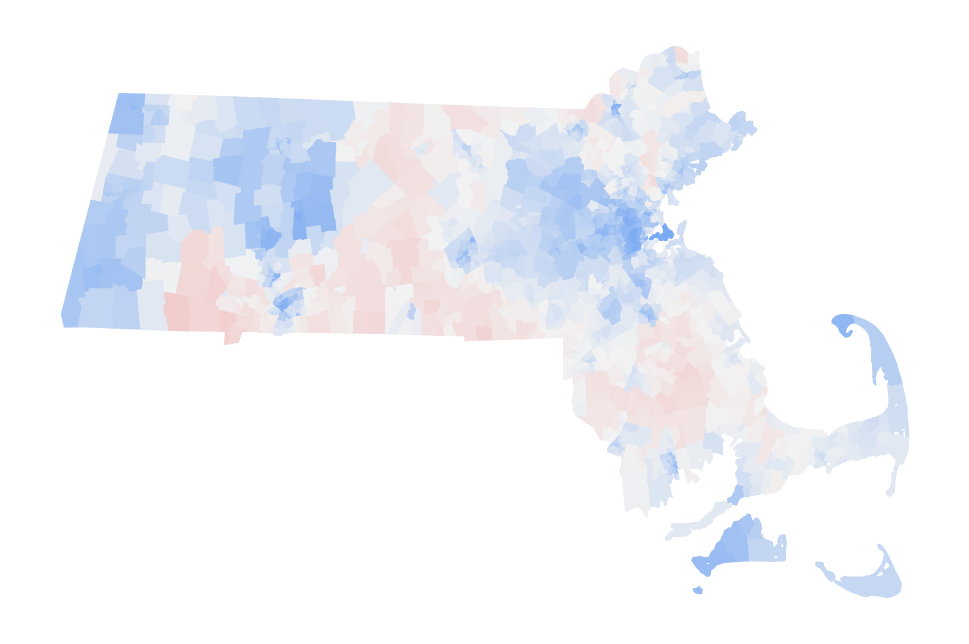

In [4]:
presidential_election_year = 2012 # Options: 2012, 2016

plot_ma_precincts(presidential_election_year)

## How votes translate to seats

In the last two cells, we'll compare how New York and Massachusetts differ in the way they translate votes to seats. We'll look at both US House Congressional data and Presidential vote share (since both states have uncontested districts-- you'll see `Warnings` printed when the code encounters one). 

Even though the Presidential Republican vote shares in the two states are very similar, Massachusetts has no Republicans win US House races, while New York has much closer to proportional numbers, thanks to the geographical distribution of Republican voters.

In [5]:
# Helper functions to read in the data for US House and Presidential elections from MEDSL

import pandas as pd
import numpy as np

historical_elections = pd.read_csv('data/1976-2018-house.csv', encoding = "ISO-8859-1")  # Load MIT Election Lab Data
presidential_elections = pd.read_csv('data/1976-2016-president.csv', encoding = "ISO-8859-1")  
def get_two_party_votes(state, year):
    in_state = historical_elections['state_po'] == state
    in_year = historical_elections["year"] == year

    results_in_state_and_year = historical_elections[in_state & in_year]

    in_republican_party = results_in_state_and_year['party'] == "republican"
    in_democratic_party = (results_in_state_and_year['party'] == "democrat") | (results_in_state_and_year['party'] == "democratic-farmer-labor")
    not_a_write_in = results_in_state_and_year['writein'] == False
    
    number_of_districts = np.amax(results_in_state_and_year['district'])
    
    district_offset = 1
    if number_of_districts == 0:
        number_of_districts = 1
        district_offset = 0

    republican_votes_by_district = []
    democrat_votes_by_district = []

    for i in range(number_of_districts):
        in_district = results_in_state_and_year['district'] == i + district_offset

        republican_in_district = results_in_state_and_year[in_district & in_republican_party & not_a_write_in]
        republican_candidates = republican_in_district['candidate'].values
        
        if len(republican_candidates) == 0:
            print('Warning! No Republican candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            republican_votes_by_district.append(0)
        else:
            # The next three lines are to handle the way New York is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == republican_in_district['candidate'].values[0]
            republican_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = republican_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            republican_vote = np.sum(np.array(all_votes_for_candidate))
            republican_votes_by_district.append(republican_vote)

        democrat_in_district = results_in_state_and_year[in_district & in_democratic_party]
        democrat_candidates = democrat_in_district['candidate'].values

        if len(democrat_candidates) == 0:
            print('Warning! No Democrat candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            democrat_votes_by_district.append(0)
        else:
            # The next lines are to handle the way New York is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == democrat_in_district['candidate'].values[0]
            democrat_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = democrat_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            democrat_vote = np.sum(np.array(all_votes_for_candidate))
            democrat_votes_by_district.append(democrat_vote)

        if republican_votes_by_district[-1] == 0 and democrat_votes_by_district[-1] == 0:
            print('Warning! No votes registered in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))

    return republican_votes_by_district, democrat_votes_by_district

def get_presidential_vote(state, year):
    in_state = presidential_elections['state_po'] == state
    in_year = presidential_elections["year"] == year

    results_in_state_and_year = presidential_elections[in_state & in_year]

    in_republican_party = results_in_state_and_year['party'] == "republican"
    in_democratic_party = (results_in_state_and_year['party'] == "democrat") | (results_in_state_and_year['party'] == "democratic-farmer-labor")
    not_a_write_in = results_in_state_and_year['writein'] == False
    
    
    republican_candidate = results_in_state_and_year[in_republican_party & not_a_write_in]
    democrat_candidate = results_in_state_and_year[in_democratic_party & not_a_write_in]

    democrat_candidate = democrat_candidate['candidate'].values[0]
    republican_candidate = republican_candidate['candidate'].values[0]

    is_republican_candidate = results_in_state_and_year['candidate'] == republican_candidate
    is_democrat_candidate = results_in_state_and_year['candidate'] == democrat_candidate

    all_votes_for_republican_candidate =  results_in_state_and_year[is_republican_candidate]
    all_votes_for_republican_candidate = np.sum(all_votes_for_republican_candidate['candidatevotes'].values)

    all_votes_for_democrat_candidate =  results_in_state_and_year[is_democrat_candidate]
    all_votes_for_democrat_candidate = np.sum(all_votes_for_democrat_candidate['candidatevotes'].values)

    return all_votes_for_republican_candidate, all_votes_for_democrat_candidate
    

def votes_to_seats(party_a_votes, party_b_votes):

    party_a_total = 0
    party_b_total = 0
    for i in range(len(party_a_votes)):
        if party_a_votes[i] > party_b_votes[i]:
            party_a_total = party_a_total + 1
        else:
            party_b_total = party_b_total + 1

    return party_a_total, party_b_total



In [6]:
# For both states, print the Republican seats won and compare to the two-party Republican vote share

for state in ["NY", "MA"]:

    for year in [2012, 2014, 2016, 2018]:
        republican_votes_by_district, democrat_votes_by_district = get_two_party_votes(state, year)
        republican_total_seats, democrat_total_seats = votes_to_seats(republican_votes_by_district, democrat_votes_by_district)

        print("\nIn " + state + " in " + str(year) + ", there were " + str(republican_total_seats) + " US House seats for Republicans and " + str(democrat_total_seats) + " seats for Democrats.\n\n")


    for year in [2012, 2016]:

        all_votes_for_republican_candidate, all_votes_for_democrat_candidate = get_presidential_vote(state, year)
        print('\nIn the ' + str(year) + ' Presidential election in ' + state + " there were:" )
        print('- ' + str(all_votes_for_republican_candidate) + " votes for the Republican candidate")
        print('- ' +str(all_votes_for_democrat_candidate) + " votes for the Democrat candidate")
        print('The 2-party Presidential vote share for Republicans across ' + state + ' in ' + str(year) + ' was: ' + str(round(all_votes_for_republican_candidate/(all_votes_for_republican_candidate + all_votes_for_democrat_candidate),3))+ '\n\n')



Warning! No Republican candidate in NY District 7 in 2012

In NY in 2012, there were 6 US House seats for Republicans and 21 seats for Democrats.


Warning! No Republican candidate in NY District 5 in 2014
Warning! No Republican candidate in NY District 6 in 2014
Warning! No Republican candidate in NY District 8 in 2014
Warning! No Republican candidate in NY District 9 in 2014
Warning! No Republican candidate in NY District 10 in 2014
Warning! No Republican candidate in NY District 13 in 2014
Warning! No Republican candidate in NY District 14 in 2014
Warning! No Republican candidate in NY District 15 in 2014
Warning! No Republican candidate in NY District 16 in 2014
Warning! No Democrat candidate in NY District 22 in 2014

In NY in 2014, there were 9 US House seats for Republicans and 18 seats for Democrats.


Warning! No Republican candidate in NY District 8 in 2016
Warning! No Republican candidate in NY District 9 in 2016
Warning! No Republican candidate in NY District 16 in 2016
War